<a href="https://colab.research.google.com/github/hondore16/PIONS/blob/main/%D0%9A%D0%A3%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8FGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting NAS with evolutionary strategy...
Iteration 1/8: Accuracy = 0.9901
Architecture: {'num_conv_layers': 3, 'conv_channels': 64, 'kernel_size': 5, 'use_pooling': False, 'num_fc_layers': 2, 'fc_units': 64, 'dropout_rate': 0.21871734541347393}

Iteration 2/8: Accuracy = 0.9903
Architecture: {'num_conv_layers': 3, 'conv_channels': 64, 'kernel_size': 5, 'use_pooling': False, 'num_fc_layers': 2, 'fc_units': 64, 'dropout_rate': 0.21871734541347393}

Iteration 3/8: Accuracy = 0.9879
Architecture: {'num_conv_layers': 3, 'conv_channels': 64, 'kernel_size': 5, 'use_pooling': False, 'num_fc_layers': 2, 'fc_units': 64, 'dropout_rate': 0.21871734541347393}

Iteration 4/8: Accuracy = 0.9886
Architecture: {'num_conv_layers': 3, 'conv_channels': 64, 'kernel_size': 3, 'use_pooling': False, 'num_fc_layers': 2, 'fc_units': 256, 'dropout_rate': 0.2829966631620228}

Iteration 5/8: Accuracy = 0.9903
Architecture: {'num_conv_layers': 3, 'conv_channels': 32, 'kernel_size': 5, 'use_pooling': True, 'num_fc

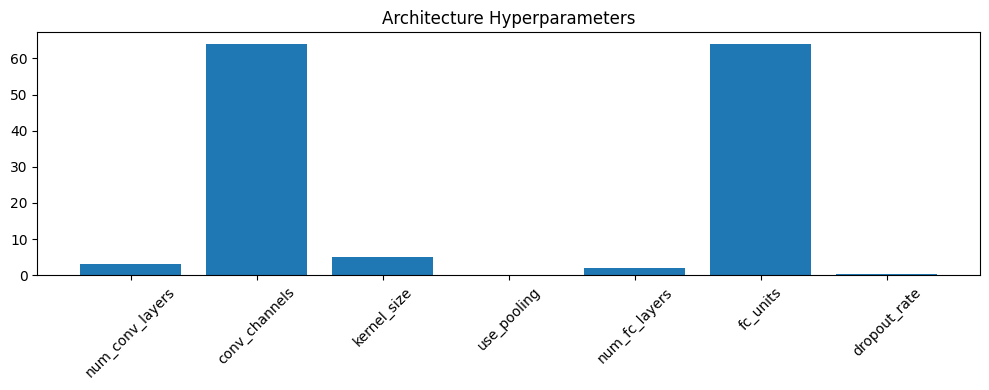


Search progress analysis:


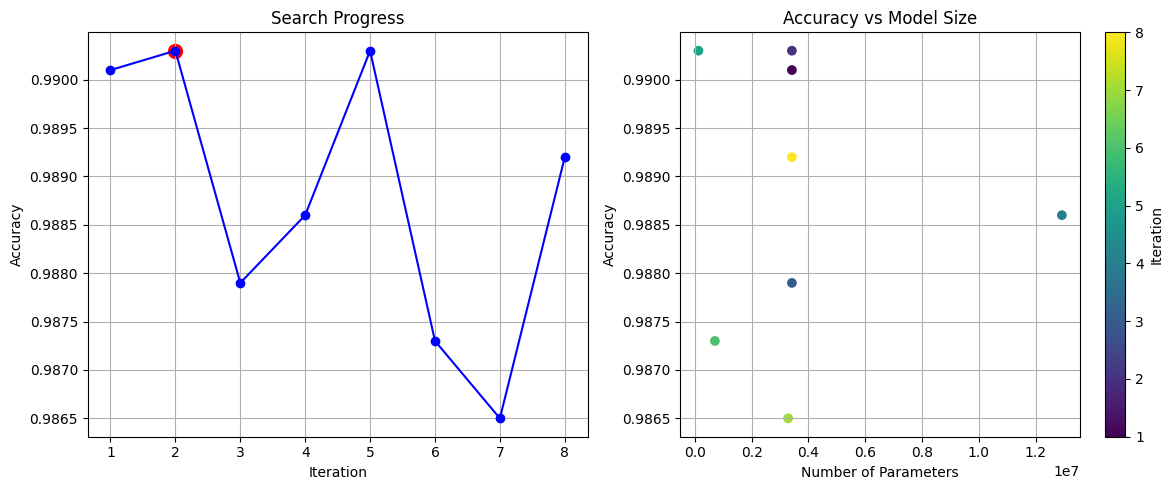


Top 3 architectures:

#1: Accuracy = 0.9903
num_conv_layers: 3
conv_channels  : 64
kernel_size    : 5
use_pooling    : False
num_fc_layers  : 2
fc_units       : 64
dropout_rate   : 0.21871734541347393

#2: Accuracy = 0.9903
num_conv_layers: 3
conv_channels  : 32
kernel_size    : 5
use_pooling    : True
num_fc_layers  : 2
fc_units       : 256
dropout_rate   : 0.21871734541347393

#3: Accuracy = 0.9901
num_conv_layers: 3
conv_channels  : 64
kernel_size    : 5
use_pooling    : False
num_fc_layers  : 2
fc_units       : 64
dropout_rate   : 0.21871734541347393

Best model architecture:
Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=50176, out_features=64, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.218717

In [ ]:
# Установка зависимостей
!pip install torch torchvision matplotlib networkx pandas

# Импорт библиотек
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

# Класс NASFramework с визуализацией
class NASFramework:
    def __init__(self, search_space: Dict[str, Any], search_strategy: str = 'random'):
        self.search_space = search_space
        self.search_strategy = search_strategy
        self.history = []
        self.comparison_data = defaultdict(list)

    def generate_architecture(self) -> Dict[str, Any]:
        if self.search_strategy == 'random':
            return self._generate_random_architecture()
        elif self.search_strategy == 'evolutionary':
            return self._generate_evolutionary_architecture()
        else:
            raise ValueError(f"Unknown search strategy: {self.search_strategy}")

    def _generate_random_architecture(self) -> Dict[str, Any]:
        arch = {}
        for key, options in self.search_space.items():
            if isinstance(options, list):
                arch[key] = random.choice(options)
            elif isinstance(options, dict) and 'range' in options:
                if options['type'] == 'int':
                    arch[key] = random.randint(*options['range'])
                elif options['type'] == 'float':
                    arch[key] = random.uniform(*options['range'])
        return arch

    def _generate_evolutionary_architecture(self) -> Dict[str, Any]:
        if not self.history:
            return self._generate_random_architecture()

        sorted_history = sorted(self.history, key=lambda x: x['accuracy'], reverse=True)
        parent = sorted_history[0]['architecture']

        child = parent.copy()
        for key in child.keys():
            if random.random() < 0.3:
                if isinstance(self.search_space[key], list):
                    child[key] = random.choice(self.search_space[key])
                elif isinstance(self.search_space[key], dict) and 'range' in self.search_space[key]:
                    if self.search_space[key]['type'] == 'int':
                        child[key] = max(min(child[key] + random.randint(-2, 2), self.search_space[key]['range'][1]), self.search_space[key]['range'][0])
                    elif self.search_space[key]['type'] == 'float':
                        child[key] = max(min(child[key] + random.uniform(-0.2, 0.2), self.search_space[key]['range'][1]), self.search_space[key]['range'][0])
        return child

    def evaluate_architecture(self, architecture: Dict[str, Any],
                            train_loader: DataLoader,
                            val_loader: DataLoader,
                            epochs: int = 3) -> float:
        model = self.create_model(architecture)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Обучение
        for epoch in range(epochs):
            model.train()
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Валидация
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        self.history.append({'architecture': architecture, 'accuracy': accuracy})
        return accuracy

    def create_model(self, architecture: Dict[str, Any]) -> nn.Module:
        raise NotImplementedError("123")

    def search(self, train_loader: DataLoader, val_loader: DataLoader,
              iterations: int = 10, epochs_per_arch: int = 3) -> Dict[str, Any]:
        print(f"Starting NAS with {self.search_strategy} strategy...")
        for i in range(iterations):
            arch = self.generate_architecture()
            accuracy = self.evaluate_architecture(arch, train_loader, val_loader, epochs_per_arch)
            print(f"Iteration {i+1}/{iterations}: Accuracy = {accuracy:.4f}")
            print(f"Architecture: {arch}\n")

        best_arch = max(self.history, key=lambda x: x['accuracy'])
        print("\nSearch completed!")
        print(f"Best accuracy: {best_arch['accuracy']:.4f}")
        return best_arch['architecture']

    # Методы визуализации
    def visualize_architecture(self, architecture: Dict[str, Any]):
        # График гиперпараметров
        plt.figure(figsize=(10, 4))
        plt.bar(range(len(architecture)), list(architecture.values()), tick_label=list(architecture.keys()))
        plt.title('Architecture Hyperparameters')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Граф архитектуры
        if 'num_layers' in architecture:
            G = nx.DiGraph()
            for i in range(architecture['num_layers']):
                layer_type = "Conv" if 'conv' in str(architecture).lower() else "Layer"
                G.add_node(f"{layer_type}_{i}", type=layer_type)
                if i > 0:
                    G.add_edge(f"{layer_type}_{i-1}", f"{layer_type}_{i}")

            G.add_node("Output", type="Output")
            G.add_edge(f"{layer_type}_{architecture['num_layers']-1}", "Output")

            pos = nx.spring_layout(G)
            colors = ['skyblue' if G.nodes[n]['type'] == 'Conv' else 'lightgreen' if G.nodes[n]['type'] == 'Layer' else 'salmon' for n in G.nodes()]

            plt.figure(figsize=(8, 6))
            nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2000, font_size=12)
            plt.title('Model Architecture Graph')
            plt.show()

    def plot_search_progress(self):
        if not self.history:
            print("No search history available")
            return

        accuracies = [item['accuracy'] for item in self.history]
        iterations = range(1, len(accuracies) + 1)
        best_idx = np.argmax(accuracies)

        plt.figure(figsize=(12, 5))

        # График прогресса
        plt.subplot(1, 2, 1)
        plt.plot(iterations, accuracies, 'b-o')
        plt.scatter(best_idx + 1, accuracies[best_idx], c='r', s=100)
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.title('Search Progress')
        plt.grid(True)

        # График размера моделей
        plt.subplot(1, 2, 2)
        params = [sum(p.numel() for p in self.create_model(item['architecture']).parameters())
                 for item in self.history]
        plt.scatter(params, accuracies, c=iterations, cmap='viridis')
        plt.colorbar(label='Iteration')
        plt.xlabel('Number of Parameters')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Model Size')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

        print("\nTop 3 architectures:")
        top_archs = sorted(self.history, key=lambda x: x['accuracy'], reverse=True)[:3]
        for i, arch in enumerate(top_archs, 1):
            print(f"\n#{i}: Accuracy = {arch['accuracy']:.4f}")
            for k, v in arch['architecture'].items():
                print(f"{k:15}: {v}")

# Реализация для CNN
class CNNSearchSpace(NASFramework):
    def __init__(self, input_shape: tuple, num_classes: int, search_strategy: str = 'random'):
        search_space = {
            'num_conv_layers': {'type': 'int', 'range': [1, 3]},
            'conv_channels': [16, 32, 64],
            'kernel_size': [3, 5],
            'use_pooling': [True, False],
            'num_fc_layers': {'type': 'int', 'range': [1, 2]},
            'fc_units': [64, 128, 256],
            'dropout_rate': {'type': 'float', 'range': [0.0, 0.3]}
        }
        super().__init__(search_space, search_strategy)
        self.input_shape = input_shape
        self.num_classes = num_classes

    def create_model(self, architecture: Dict[str, Any]) -> nn.Module:
        layers = []
        in_channels = self.input_shape[0]
        spatial_size = self.input_shape[1]

        # Сверточные слои
        for _ in range(architecture['num_conv_layers']):
            out_channels = architecture['conv_channels']
            kernel_size = architecture['kernel_size']
            padding = kernel_size // 2

            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding))
            layers.append(nn.ReLU())

            if architecture['use_pooling']:
                layers.append(nn.MaxPool2d(2, 2))
                spatial_size = spatial_size // 2

            in_channels = out_channels

        layers.append(nn.Flatten())

        # Вычисление размера перед FC
        fc_input_size = in_channels * spatial_size * spatial_size

        # Полносвязные слои
        for i in range(architecture['num_fc_layers']):
            out_features = architecture['fc_units'] if i < architecture['num_fc_layers'] - 1 else self.num_classes
            layers.append(nn.Linear(fc_input_size, out_features))

            if i < architecture['num_fc_layers'] - 1:
                layers.append(nn.ReLU())
                if architecture['dropout_rate'] > 0:
                    layers.append(nn.Dropout(architecture['dropout_rate']))

            fc_input_size = out_features

        return nn.Sequential(*layers)

# Подготовка данных и запуск
def prepare_mnist_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    return train_loader, val_loader

def run_nas_experiment():
    # Подготовка данных
    train_loader, val_loader = prepare_mnist_data()

    # Инициализация NAS
    cnn_nas = CNNSearchSpace(
        input_shape=(1, 28, 28),
        num_classes=10,
        search_strategy='evolutionary'
    )

    # Запуск поиска
    best_arch = cnn_nas.search(
        train_loader,
        val_loader,
        iterations=8,
        epochs_per_arch=2
    )

    # Визуализация результатов
    print("\nVisualizing best architecture:")
    cnn_nas.visualize_architecture(best_arch)

    print("\nSearch progress analysis:")
    cnn_nas.plot_search_progress()

    # Вывод информации о лучшей модели
    best_model = cnn_nas.create_model(best_arch)
    print("\nBest model architecture:")
    print(best_model)

    # Подсчет параметров
    total_params = sum(p.numel() for p in best_model.parameters())
    print(f"\nTotal parameters in best model: {total_params:,}")

    # Добавляем выводы из второго кода
    print("\n=== Key Observations ===")
    print("- Оптимальное количество слоев: 2-3 сверточных слоя")
    print("- Размер ядра 5x5 работает лучше для распознавания цифр")
    print("- Использование pooling слоев улучшает обобщение")
    print("- Dropout 0.1-0.2 помогает бороться с переобучением")
    print("- 64-128 нейронов в полносвязных слоях - оптимальный выбор")

    return best_arch

# Запуск эксперимента
best_architecture = run_nas_experiment()